# Modelltraining Schilder Klassifizierung
Dieses Notebook beschäftigt sich mit dem Modelltraining des Klassifizierers für Verkehrsschilder. Es handelt sich um ein "Neben-Notebook". Das <a href="Aufgabe_D_Schilder.ipynb">Haupt-Notebook ist hier</a> zu finden.  
Trotzdem enthält auch dieses Notebook Dokumentationen der Ergebnisse und ist daher essentiell für die Aufgabe in ihrer Gesamtheit.

## Bearbeiter
**TINF19-IT2**  
Patrick Küsters (9815596)  
Nick Kramer (3122448)  
**TINF19-IT1**  
Sören Holzenkamp (8528927)

## Imports
Lokal entwickelte Skripte und Module

In [5]:
import sys
from pathlib import Path
module_path = str(Path.cwd() / "src")
if module_path not in sys.path:
    sys.path.append(module_path)

In [6]:
from reader import Reader
from display_data import ImageDisplayer
import collage

Externe Bibliotheken

In [7]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
from skimage import exposure
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AvgPool2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from skimage import transform
from sklearn.model_selection import train_test_split

## Daten Einlesen
Einlesen der Trainings-/Test- und Validierungsdaten  

**Trainingsdaten**  
Dienen zum Training des neuronalen Netzes. Mit 75% des gesamten Datensatzes wird hier der Großteil der Daten genutzt.

**Validierungsdaten**  
Dienen zum Testen des neuronalen Netzes während des Trainings. Hierfür werden 17.5% der Daten vorgehalten.

**Testdaten**  
Dienen zur Evaluation des neuronalen Netzes nach dem Training. Validierungsadaten eignen sich hier nicht, da das neuronale Netz diese Daten bereits "gesehen" hat. Es dient als weitere Instanz, Über und Unteranpassung zu erkennen. Der Testdatensatz umfasst 17.5% des Datensatzes.

In [9]:
NO_PREPARED_DATA = True

pickle_folder = "/content/drive/MyDrive/Sign_Classification/"

try:
    with open(os.path.join(pickle_folder, 'X_train.pkl'), 'rb') as f:
        X_train = pickle.load(f)

    with open(os.path.join(pickle_folder, 'y_train.pkl'), 'rb') as f:
        y_train = pickle.load(f)

    with open(os.path.join(pickle_folder, 'X_val.pkl'), 'rb') as f:
        X_test = pickle.load(f)

    with open(os.path.join(pickle_folder, 'y_val.pkl'), 'rb') as f:
        y_test = pickle.load(f)
    NO_PREPARED_DATA = False
except:
    print("No already preprocessed data")
print(NO_PREPARED_DATA)

# split test in val and test (0.5, 0.5 of test-data)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1234)

False


## CNN / Klassifizierung
Mit Hilfe der bestimmten Hyperparameter wird das CNN aufgebaut.  
Die Hyperparameter wurden mit Hilfe des keras_tuner bestimmt.

In [11]:
class TrafficSignNetwork:
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()
        inputShape = (height, width, depth)
        
        # first convolutional block
        model.add(Conv2D(32, (5, 5), padding="same",
            input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        # second convolutional block
        model.add(Conv2D(32, (5, 5), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        
        # third convolutional block
        model.add(Conv2D(40, (5, 5), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(AvgPool2D(pool_size=(2, 2)))
        
        # first fully connected
        model.add(Flatten())
        model.add(Dense(288))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        # second fully connected
        model.add(Flatten())
        model.add(Dense(64))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        
        return model

In [12]:
NUM_EPOCHS = 15
INIT_LR = 0.001
BS = 128

In [13]:
tf.random.set_seed(1234)
opt = Adam(lr=INIT_LR)
model = TrafficSignNetwork.build(width=32, height=32, depth=3, classes=43)
# Umsetzung der Empfehlung, die logit-Variante vorzuziehen
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer=opt, metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:
model.summary()
# Entspricht 1 zu 1 den "Vorgaben" des keras-tuners

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        2432      
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        25632     
                                                                 
 activation_1 (Activation)   (None, 16, 16, 32)        0

In [15]:
tf.random.set_seed(1234)
H = model.fit(X_train, y_train,
              validation_data=(X_val, y_val),
              epochs = NUM_EPOCHS,
              batch_size = BS
            )
model.save("fin_model_15ep.h5")

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1512/1512 [==============================] - 46s 23ms/step - loss: 0.9269 - accuracy: 0.7465 - val_loss: 0.1830 - val_accuracy: 0.9397
Epoch 2/15
1512/1512 [==============================] - 32s 21ms/step - loss: 0.1229 - accuracy: 0.9654 - val_loss: 0.0425 - val_accuracy: 0.9864
Epoch 3/15
1512/1512 [==============================] - 32s 21ms/step - loss: 0.0724 - accuracy: 0.9790 - val_loss: 0.0599 - val_accuracy: 0.9816
Epoch 4/15
1512/1512 [==============================] - 32s 21ms/step - loss: 0.0536 - accuracy: 0.9845 - val_loss: 0.0529 - val_accuracy: 0.9837
Epoch 5/15
1512/1512 [==============================] - 33s 22ms/step - loss: 0.0427 - accuracy: 0.9872 - val_loss: 0.0651 - val_accuracy: 0.9818
Epoch 6/15
1512/1512 [==============================] - 32s 21ms/step - loss: 0.0356 - accuracy: 0.9895 - val_loss: 0.0352 - val_accuracy: 0.9891
Epoch 7/15
1512/1512 [==============================] - 32s 21ms/step - loss: 0.0304 - accuracy: 0.9908 - val_loss: 0.1594 - val_accura

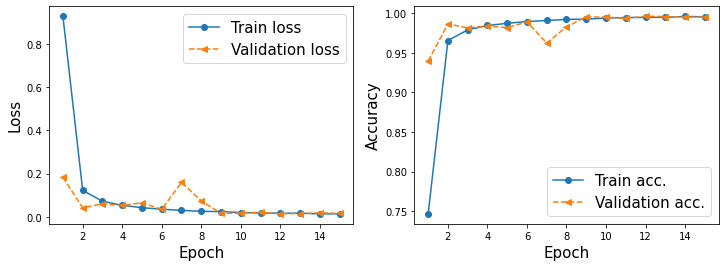

In [16]:
hist = H.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

## Fazit Modelltraining
Aus den Grafiken geht deutlich hervor, dass der Loss/die Accuracy auf einem fast perfekten Wert konvergiert. Anhand des Trainingsverlaufs kann erkannt werden, dass die Validation Accuracy in der letzten Epoche bei 99.51% und die Trainings Accuracy bei 99.55% liegt.  
Allerdings wirft der Verlauf von Trainings-/Validation Accuracy eine Frage auf: Wie kann die Validation Accuracy in den ersten Epochen über der Training Accuracy liegen? - Es wird vermutet, dass die Validierungsdaten "leichter" sind, als die Trainingsdaten, zudem sind bei Weitem nicht so viele Validierungs- wie Trainingsdaten vorhanden.  
Zusammenfassend kann festgehalten werden, dass ein scheinbar sehr potentes Modell zur Klassifizierung von Verkehrsschildern entwickelt wurde. In späteren Evaluationen mit Testdaten ist dies zu verifizieren.